In [ ]:
!pip install pandas numpy matplotlib gensim nltk tqdm xgboost scikit-learn


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from gensim.utils import simple_preprocess
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
import pandas as pd

# Load the dataset using 'latin-1' encoding
data = pd.read_csv('/content/sexism_final_2.csv', encoding='latin-1')

# Check the data
print(data.head())

                                                text      target
0  MENTION3481 i didn't even know random was an o...  Non-sexism
1                   Bottom two should've gone!  #mkr  Non-sexism
2  MENTION3111 MENTION3424 ladyboner deserves so ...  Non-sexism
3  She shall now be known as Sourpuss #MKR #KatAn...  Non-sexism
4  Tarah W threw a bunch of women under the bus s...  Non-sexism


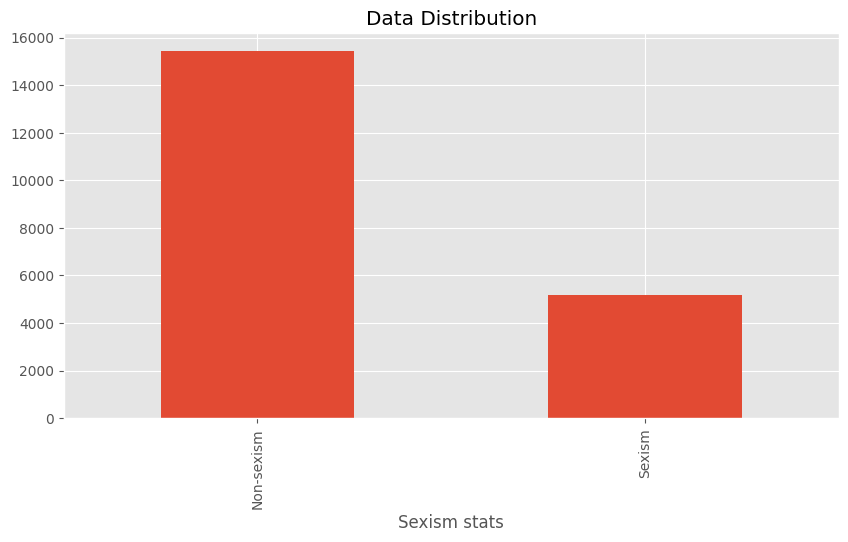

In [25]:
plt.style.use('ggplot')
ax = data['target'].value_counts().sort_index()\
.plot(kind='bar',
      title='Data Distribution',
      figsize=(10,5))
ax.set_xlabel("Sexism stats")
plt.show()

In [9]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK datasets
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function for text preprocessing
def preprocess_text(text):
    # Remove non-alphabetic characters (e.g., punctuation)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Split into words
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]  # Lemmatize and remove stopwords
    return ' '.join(text)

# Apply preprocessing to the reviews
data['Processed_target'] = data['target'].apply(preprocess_text)

# Check the first few processed reviews
print(data[['target', 'Processed_target']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


       target Processed_target
0  Non-sexism       non sexism
1  Non-sexism       non sexism
2  Non-sexism       non sexism
3  Non-sexism       non sexism
4  Non-sexism       non sexism


In [10]:
from sklearn.model_selection import train_test_split

X = data['Processed_target']  # Features (processed reviews)
y = data['target']  # Target (labels: positive or negative)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(X_train.shape, X_test.shape)


(16486,) (4122,)


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = vectorizer.transform(X_test)

# Check the shape of the resulting feature matrices
print(X_train_tfidf.shape, X_test_tfidf.shape)


(16486, 2) (4122, 2)


In [12]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Check the accuracy of the model
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

  Non-sexism       1.00      1.00      1.00      3086
      Sexism       1.00      1.00      1.00      1036

    accuracy                           1.00      4122
   macro avg       1.00      1.00      1.00      4122
weighted avg       1.00      1.00      1.00      4122



In [13]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga']  # Solvers to try
}

# Initialize the GridSearchCV with Logistic Regression
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3, n_jobs=-1)

# Fit the grid search on the training data
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")


Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
Best Score: 1.0


In [20]:
# Example test review
test_review = "Women do not belong in politics"

# Preprocess the review
processed_review = preprocess_text(test_review)

# Transform the review using the same TF-IDF vectorizer
test_review_tfidf = vectorizer.transform([processed_review])

# Predict the sentiment
predicted_label = model.predict(test_review_tfidf)

print(f"Predicted Sentiment: {predicted_label[0]}")


Predicted Sentiment: ['Non-sexism']
